In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(N,difftemp,P,temp,nSteps,dt,last = True):
    if last:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
    else:
        return np.load(f"data_N{N}_T{difftemp:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
def load_original_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [ ]:
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)

L = 10
N = L**2
P = 100000
difftemp = 8
nSteps = 300
dt = 0.02
Ts[10]

In [3]:

slices = np.geomspace(1,nSteps,9, dtype = np.int32)   
slices

array([  1,   2,   4,   8,  17,  35,  72, 147, 300], dtype=int32)

In [4]:
x_recon = np.empty((meas,P,9,N))
for i,T in enumerate(Ts):
    x_recon[i] = load_data(N,difftemp,P,T,nSteps,dt)
x_true = np.empty((meas,200000,N))
for i,T in enumerate(Ts):
    x_true[i] = load_original_data(L,T,200000)

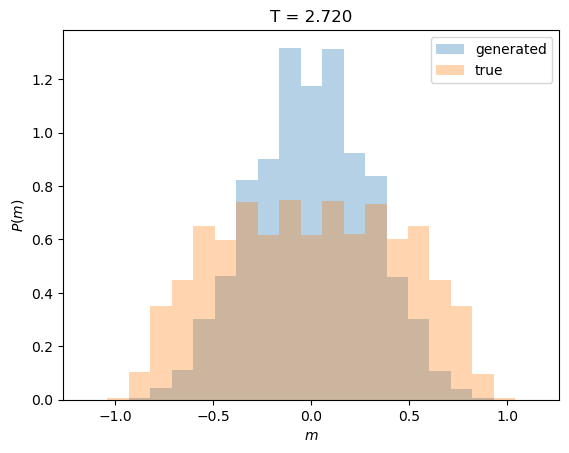

In [19]:
idx= 9
plt.title(f"T = {Ts[idx]:.3f}")
plt.hist(np.mean(np.sign(x_recon[idx,:,-1,:]),axis = 1),range=(-1.15,1.15),bins = 21,alpha = 1/3,density = True, label = "generated")
#plt.hist(np.mean(x_recon[idx,:,-1,:],axis = 1),range=(-1.15,1.15),bins = 21,alpha = 1/3,density = True, label = "generated no sign")
plt.hist(np.mean(x_true[idx],axis = 1),range=(-1.15,1.15),bins = 21,alpha =1/3,density = True, label = "true")
plt.ylabel(r"$P(m)$")
plt.xlabel(r"$m$")
plt.legend()